# Backpropagation on DAGs

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/fundamentals/backpropagation.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

## Introduction

In this notebook, we will look at **backpropagation** on directed acyclic computational graphs (DAGs). Our main result is that a training step for a single data point, consisting of both a forward and a backward pass, has a time complexity that is linear in the number of edges of the graph. This is interesting since it turns out that we can represent neural networks as computational graphs. I used the following resources in writing this notebook: {cite}`timviera`, {cite}`backprop-offconvex`, {cite}`pytorch-autograd`, and {cite}`micrograd`.

## Gradient descent on the loss surface

For every data point $(\boldsymbol{\mathsf x}, \mathsf{y})$, the loss function $\ell$ returns a nonnegative value that approaches zero whenever the predictions $f_{\boldsymbol{\Theta}}(\boldsymbol{\mathsf x})$ approach the target values $\mathsf y$. The loss is designed to give penalty to bad predictions depending on the context or problem setup. More precisely, the loss acts as an almost-everywhere differentiable surrogate to the true objective which is generally non-differentiable metric (e.g. accuracy).

Training neural networks is essentially an optimization problem with the loss as objective. Given the current parameters $\boldsymbol{\Theta} \in \mathbb R^d$ of the network, we can imagine the network to be sitting on a point $(\boldsymbol{\Theta}, \mathcal L(\boldsymbol{\Theta}))$ on a surface in $\mathbb R^d \times \mathbb R$ where $\mathcal L(\boldsymbol{\Theta})$ is the average loss over the dataset:

$$
\mathcal L(\boldsymbol{\Theta}) = \frac{1}{|\mathcal X|} \sum_{(\boldsymbol{\mathsf x}, \mathsf{y}) \in \mathcal X} \ell(\mathsf{y}, f_{\boldsymbol{\Theta}}(\boldsymbol{\mathsf x})).
$$

The surface will generally vary for different samples of the training data, but we except the surfaces to be very similar assuming the samples are independently drawn from the same distribution. Training is equivalent to finding the minimum of this surface. The first derivatives give us information about the local slope of the surface which we can use to make the first-order approximation:

$$\Delta \mathcal L \approx  \sum_k \left(\frac{\partial \mathcal L}{ \partial {\Theta}_k} \right)  \Delta {\Theta}_k = \nabla_{\boldsymbol{\Theta}}\, \mathcal L \cdot \Delta {\boldsymbol{\Theta}}.$$ 

It follows that $-\nabla_{\boldsymbol{\Theta}}\, \mathcal L$ is the direction of steepest descent at the current point in the surface. The update rule 
$\boldsymbol{\Theta} \leftarrow \boldsymbol{\Theta} - \lambda \nabla_{\boldsymbol{\Theta}}\, \mathcal L$ where $\lambda > 0$ results in a network that is closer to the minimum of the loss surface.

**Remark.** The factor $\lambda$ is called the learning rate that controls the step size. Using a fixed learning rate can result in weights that overshoot, or be too slow in converging, to the minimum. This explains why second-order methods which use second derivatives (i.e. the Hessian) are used to measure local surface curvature. This is impractical to compute for large number of weights. Instead, more commonly used methods combine adaptive learning rates and momentum for training large networks.

```{figure} ../../img/loss_surface_resnet.png
---
name: loss-surface-resnet
width: 35em
---
Loss surface for ResNet-56 with or without skip connections. Much of deep learning research is dedicated to studying the geometry of loss surfaces and its effect on optimization. {cite}`arxiv.1712.09913`
```

```{margin}
**The need for efficient BP**
```

Observe that $\nabla_{\boldsymbol{\Theta}}\, \mathcal L$ consists of partial derivatives for each weight in the network which can easily number in millions. Thus, we will perform computation of derivatives in an efficient way for this training with gradient-based methods to be feasible. It turns out that we can perform this with time complexity that is linear with the number of weights. Furthermore, the development of sophisticated hardware for parallel computation (e.g. GPUs) has reduced training time by a significant factor, resulting in the viability of neural network models for pratical uses.

**Remark.** Since the loss is a sum over pointwise losses, it suffices to compute gradients for loss surfaces generated by a single input-output pair $(\boldsymbol{\mathsf x}, \mathsf{y}) \in \mathcal X$ to compute the gradient of the empirical loss over $\mathcal X$ by linearity in $\nabla_{\boldsymbol{\Theta}}.$ In other words, computing the gradient is an embarassingly parallel task over the data points.
Indeed, our discussion and implementation below uses pointwise losses. 

## Backpropagation on computational graphs

A neural network can be modelled as a directed acyclic graph (DAG) of compute and parameter nodes that implements a function $f$ and can be extended to implement the calculation of the loss value for each training example and parameter values. Note that we can always perturb the value of the loss node at the current state of the graph (i.e. the current values of its nodes) by perturbing the values in each node. This results in perturbations flowing up to the final loss node. Assuming each computation is differentiable, we can compute the partial derivative of the loss with respect to each graph node. In this section, we will look at an algorithm for computing partial derivatives of computational graphs.

Our computational DAGs will consist of **compute nodes** and **parameter nodes**. A compute node simply implements a function of values of nodes that are directed to it. This doesn't have to implement atomic functions. In fact, we will implement compute nodes at various levels of abstraction. The choice generally depends on design considerations. On the other hand, parameter nodes simply store values which ultimately determines the function $f.$ Hence, our goal is to modify the parameter node values that minimizes the empirical loss.

To achieve this, we will use the fundamental property of DAGs that it has a **topological sorting**. Observe that a DAG always has a node that has no outgoing edges (just follow a path until the last node). For our purposes, we know that this is precisely the loss node of our graph. Then, we can perform [Kahn's algorithm](https://www.youtube.com/watch?v=cIBFEhD77b4) starting with the loss node to determine the "layers" of the DAG, i.e. the order index of each node in the topological sorting.

```{figure} ../../img/compute.svg
---
width: 30%
name: compute
---
Compute and parameter node as input to another compute node. Note that parameter nodes always have zero fan-in.
```

### Forward pass

To compute $f(\boldsymbol{\mathsf x})$, the input $\boldsymbol{\mathsf x}$ is passed to the input nodes, then all compute nodes are executed up to the loss node following the directions and operations specified by the nodes and their edges. Note that node executions can occur asynchronously, e.g. in parallel. Moreover, each compute node is executed exactly once with the output value stored in the node. This will preserve the current network state for backward pass, and avoids any recomputation for nodes in the next layer. So assuming a node with $n$ inputs executes $n$ operations, then one forward pass takes $\mathcal{O}(E)$ calculations were $E$ is the number of edges of the graph. For neural networks the number of edges is proportional to the number of weights and activation units of the network.

### Backward pass

During backward pass gradients are categorized into two types: **local gradients** which are derivatives between adjacent nodes, and derivatives of the loss with respect to the node called **backpropagated gradients** since it is propagated backward from the loss node into the current node. Recall from above that our goal is to calculate the backpropagated gradient of the loss with respect to each parameter node.

**BP proceeds recursively.** We will assume that the graph has been topologically sorted. For neural networks, there is no need to do this since we already have a natural ordering defined by the layers. 
For the base step, the gradient of the compute node for the loss is set to $1$ (i.e. its derivative with itself) and stored in memory. Iterating backwards in the sorted list of nodes, we know that the backpropagated gradient for each compute node $\mathsf v$ that depends on $\mathsf u$ is already stored. Moreover, all local gradients between $\mathsf u$ and $\mathsf v$ are [computable at runtime](https://en.wikipedia.org/wiki/Automatic_differentiation). Then, the backpropagated gradient with respect to node $\mathsf u$ can be calculated using the chain rule:

$$
{\frac{\partial\mathcal L}{\partial {\mathsf u}} } = \sum_{ {\mathsf v} } \left( {{\frac{\partial\mathcal L}{\partial{\mathsf v}}}} \right) \left( {{\frac{\partial{\mathsf v}}{\partial {\mathsf u}}}} \right).
$$

```{figure} ../../img/backward-1.svg
---
width: 80%
name: backward-1
---
Computing the backpropagated gradient for a single node. Note that gradient type is distinguished by color: local (red) and global (blue).
```

This can be visualized as gradients "flowing" to each network node from the loss node. Observe that the flow of gradients end on parameter nodes since these nodes have zero fan-in. Here the partial derivatives are evaluated on the current network state with values obtained during forward pass. Hence, forward pass should always precede backward pass. Moreover, as required by the algorithm all backpropagated gradients are stored in each compute node for use by the next layer. Memory can be released after the weights are updated. On the other hand, there is no need to store local gradients; these are computed as needed. 
    
**Remark.** BP is a useful tool for understanding how derivatives flow through a model. This can be extremely helpful in reasoning about why some models are difficult to optimize. Classic examples are vanishing or exploding gradients as we go into deeper layers of the network.

### Backpropagation algorithm

Now that we know how to compute each backpropagated gradient, we can implement this as a method `u.backward()` for each node `u` that sends the gradient of the loss with respect to `u` to all nodes that depend on it. Every backpropagated gradient that is sent to a node is accumulated in a sum. Hence, we have to zero it out at the start of every trainng step.

```python
class CompGraph:
    # ...

    def forward(self, inputs):
        self.pass_inputs(inputs)
        for node in self.nodes_toposorted():
            node.forward()

    def backward():
        for node in self.nodes():
            node.grad = 0

        for node in reversed(self.nodes_toposorted()):
            node.backward()
```

<br>

Properties of the algorithm which makes it the practical choice for training huge neural networks are:

* **Modularity.** For neural networks, the dependence only on nodes belonging to the upper layer suggests a modularity in implementing neural networks, i.e. we can connect DAG subnetworks with possibly distinct network architectures by only connecting outermost nodes that are exposed between layers.

<br>

* **Efficiency.** Iterating over all nodes in the network during backward pass covers all the edges in the network with no edge counted twice. Assuming computing local gradients take constant time, then backward pass requires ${\mathcal O}(E)$ computations. For neural networks this is proportional to the number of neurons and parameters (i.e. the network size). Furthermore, the chain rule between nodes on the same layer and nodes in the upper layer of a network can be implemented as matrix multiplication for which there exist [highly optimized implementations](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms). This is done in the next section.

## Creating and training a neural net from scratch

In this section, we will implement an actual computational graph with nodes that implement `backward` for backpropagation. For this we define a class `Node` which is the implementation of compute node discussed above. This class implements all binary operations and all activations for nodes in a neural network. Each node has a `.data` attribute which stores its output value and a `.grad` attribute which stores the global gradient. Below we can see that `backward` implements chain rule to solve for `.grad`:

```python
def backward(self):
    if self._degree == 0:
        for parent in self._parents:
            parent.grad += self.grad * self._local_grad(parent)
            parent._degree -= 1
            parent.backward()
```

The formula for local gradients for the current node with respect to a parent node is implemented in `_local_grad` and must be defined for each particular operation. Observe that a node has to wait for all incoming gradients from dependent nodes before passing the gradient to its parents. This is why we define the `_degree` attribute which is decreased each time a backpropagated gradient is received by a node. 

When the degree is decreased to zero, i.e. all gradients from dependent nodes have accumulated, the node then pushes its gradient backward to its parent nodes. This is essentially [Kahn's algorithm](https://www.youtube.com/watch?v=cIBFEhD77b4&t=366s) for topological sorting. Note that a freshly created node starts with zero degree and is incremented each time a child node is created from it.

### Compute nodes

In [1]:
import math
<<<<<<< local
import random
=======
>>>>>>> remote
from abc import ABC, abstractmethod


class Node:
    def __init__(self, data, label=''):
        self.data = data
        self.grad = 0  # = ∂(loss)/∂(self)
        self.label = label
        self._degree = 0  # No. of children
        self._parents = ()  # Terminal node 

    def __repr__(self):
        return f"Node(data={self.data}, label={self.label}, grad={self.grad})"

    def __add__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='+')

    def __sub__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='-')

    def __mul__(self, other):
        self._degree += 1
        other._degree += 1
        return BinaryOpNode(self, other, op='*')

    def __pow__(self, n):
        assert isinstance(n, int) and n > 1
        self._degree += 1
        return PowOp(self, n)

    def relu(self):
        self._degree += 1
        return ReLUNode(self)

    def tanh(self):
        self._degree += 1
        return TanhNode(self)

For each of the compute nodes, the output value and the `self._local_grad(parent)` method has to be defined which computes the gradient of `self.data` with respect to `parent.data`.

In [2]:
class ComputeNode(Node, ABC):
    def __init__(self, data, label='', parents=(), op=''):
        super().__init__(data, label)
        self._parents = parents
        self._op = op

    def backward(self):
        """Send global gradient backward to parent nodes."""
        if self._degree == 0:
            for parent in self._parents:
                parent.grad += self.grad * self._local_grad(parent)
                parent._degree -= 1
<<<<<<< local
                parent.backward() if isinstance(parent, ComputeNode) else ""
    
    @abstractmethod
    def _local_grad(self, parent) -> float:
        """Compute local gradient ∂(self) / ∂(parent)."""
=======
                if isinstance(parent, ComputeNode):
                    parent.backward()
        elif self._degree < 0:
            raise Exception("Degree must be nonnegative.")
    
    @abstractmethod
    def _local_grad(self, parent) -> float:
        """Local gradients ∂(self.data)/∂(parent.data) for each parent node."""
>>>>>>> remote
        return 0.0

Defining operations between nodes. Notice that for a vanilla neural network, we don't need much:

In [3]:
class BinaryOpNode(ComputeNode):
    def __init__(self, x, y, op, label=None):
        """Binary operation between two nodes."""
        ops = {
            '+': lambda x, y: x + y,
            '-': lambda x, y: x - y,
            '*': lambda x, y: x * y
        }
        label = f'({x.label}{op}{y.label})' if not label else label
        super().__init__(ops[op](x.data, y.data), label, (x, y), op) # ... = delayed        

    def _local_grad(self, parent):
        if self._op == '+':
            return 1.0
        
        elif self._op == '-':
            i = self._parents.index(parent)
            return 1.0 if i == 0 else -1.0
            
        elif self._op == '*':
            i = self._parents.index(parent)
            coparent = self._parents[1 - i]
            return coparent.data


class ReLUNode(ComputeNode):
    def __init__(self, x):
        data = x.data * int(x.data > 0.0)
        super().__init__(data, f'relu({x.label})', (x,), 'relu')

    def _local_grad(self, parent):
        return float(parent.data > 0)


class TanhNode(ComputeNode):
    def __init__(self, x):
        data = math.tanh(x.data)
        super().__init__(data, f'tanh({x.label})', (x,), 'tanh')

    def _local_grad(self, parent):
        return 1 - self.data**2


class PowOp(ComputeNode):
    def __init__(self, x, n):
        self.n = n
        data = x.data ** self.n
        super().__init__(data, f'({x.label})**{self.n}', (x,), 'pow')

    def _local_grad(self, parent):
        return self.n * parent.data ** (self.n - 1)

### Graph vizualization

The next two functions help to visualize networks. The `trace` function just walks backward into the graph to collect all nodes and edges. This is used by the `draw_graph` which first draws all nodes, then draws all edges. For compute nodes we add a small juncture node which contains the name of the operation.

In [4]:
# https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
from graphviz import Digraph

def trace(root):
    """Builds a set of all nodes and edges in a graph."""

    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            if isinstance(v, ComputeNode):
                for child in v._parents:
                    edges.add((child, v))
                    build(child)
                    
    build(root)
    return nodes, edges


def draw_graph(root):
    """Build diagram of computational graph."""
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:

        # Add node to graph    
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.label[:30]} | data={n.data:.3f} | grad={n.grad:.4f} | deg={n._degree}", shape='record')
        
        # Connect node to op node if operation
        # e.g. if (5) = (2) + (3), then draw (5) as (+) -> (5).
        if isinstance(n, ComputeNode):
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for child, v in edges:
        # Connect child to the op node of v
        dot.edge(str(id(child)), str(id(v)) + v._op)
    
    return dot

Creating graph for a dense unit. Observe that `x1` has a degree of 2 since it has two children.

<<<<<<< local


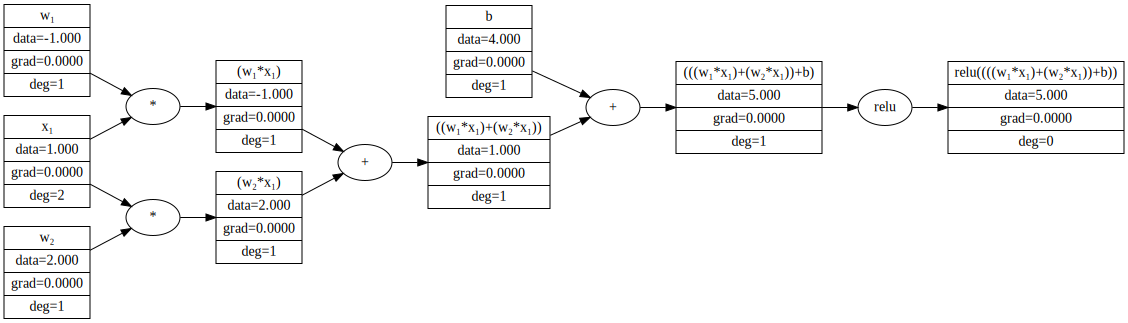

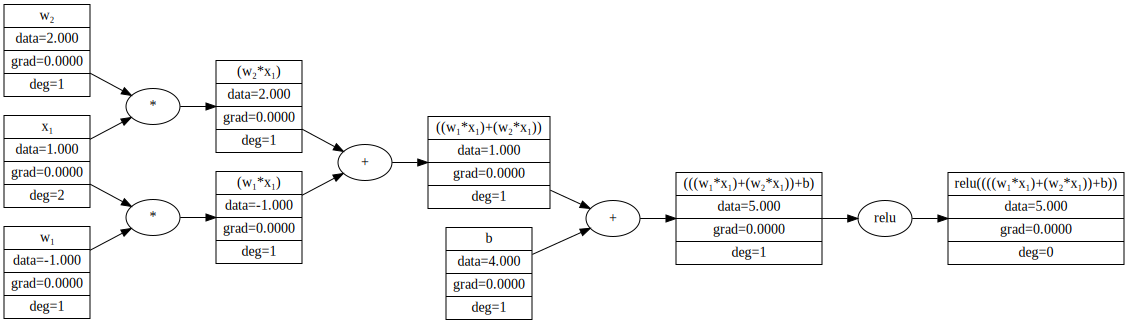

>>>>>>> remote


In [5]:
w1 = Node(-1.0, label='w₁')
w2 = Node( 2.0, label='w₂')
b  = Node( 4.0, label='b')
x1 = Node( 1.0, label='x₁')

z = w1 * x1 + w2 * x1 + b
y = z.relu()
draw_graph(y)

<<<<<<< local
Backward pass can be done by setting the initial gradient of the final node, then calling backward on it. Recall for the loss node `loss.grad = 1.0`. Observe that all gradients check out. Also, that all degrees are zero, which means we did not overshoot the updates. This also means we can't execute `.backward()` twice. 
=======
Backward pass can be done by setting the initial gradient of the final node, then calling backward on it. Recall for the loss node `loss.grad = 1.0`. Observe that all gradients check out. Also note that all degrees are zero which means we did not overshoot the updates. This also means we can't execute `.backward()` twice. 
>>>>>>> remote

<<<<<<< local


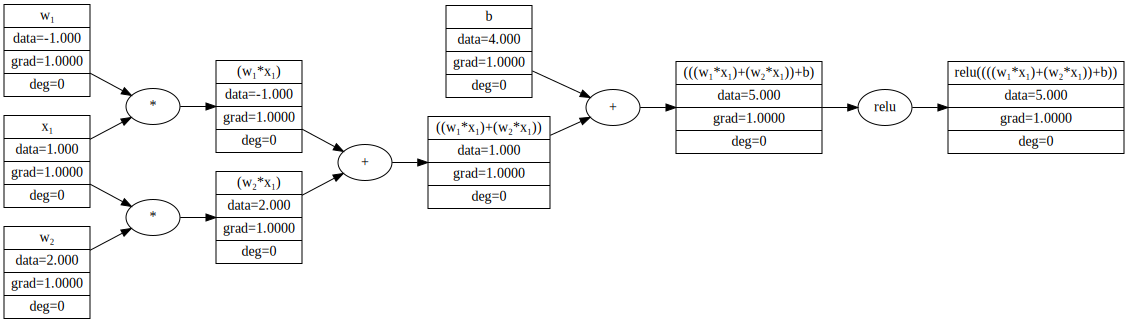

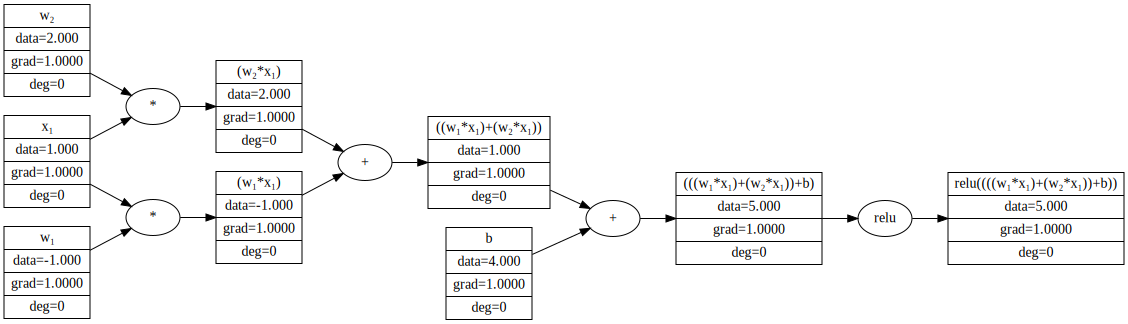

>>>>>>> remote


In [6]:
y.grad = 1.0
y.backward()
draw_graph(y)

### Neural network

In this section, we will construct the neural network module incrementally. First, let us define an abstract class `Module` which is a computational graph that maintains a list of the parameter nodes for computing `__call__`. Using `@abstractproperty` is probably a better approach for forcing having a parameters attribute, since it forces one to define an attribute setter (i.e. the line `self._parameters = []` here). But that solution looks really ugly. 

In [7]:
class Module(ABC):
    def __init__(self):
        self._parameters = []

    def parameters(self):
        return self._parameters # avoids recompute

    @abstractmethod
    def __call__(self, x: list):
        pass

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

<span style="color:red">**<<<<<<< local**</span>

A neuron computes $\mathsf{o}_k = \varphi(\boldsymbol{\mathsf x} \cdot \boldsymbol{\mathsf w}_k + \mathsf{b}_k)$. A layer simply consists of multiple neurons. Finally, an MLP is just a stack of layers. Note that the final layer has no activation. This allows flexibility on the functions that we can apply on the outputs of the network.

In [8]:
import numpy as np

class Neuron(Module):
    
    def __init__(self, n_in, nonlinear=True, activation='relu'):
        self.n_in = n_in
        self.act = activation
        self.nonlin = nonlinear

        self.w = [Node(random.random()) for _ in range(n_in)]
        self.b = Node(0.0)
        self._parameters = self.w + [self.b] 

    def __call__(self, x: list):
        assert len(x) == self.n_in
        out = sum((x[j] * self.w[j] for j in range(self.n_in)), start=self.b)
        if self.nonlin:
            out = out.tanh() if self.act == 'tanh' else out.relu()
        return out

    def __repr__(self):
        return f"{self.act if self.nonlin else 'linear'}({len(self.w)})"


class Layer(Module):

    def __init__(self, n_in, n_out, *args):
        self.neurons = [Neuron(n_in, *args) for _ in range(n_out)]
        self._parameters = [p for n in self.neurons for p in n.parameters()]

    def __call__(self, x: list):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def __repr__(self):
        return f"Layer[{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):

    def __init__(self, n_in, n_outs, activation='relu'):
        sizes = [n_in] + n_outs
        self.layers = [Layer(sizes[i], sizes[i+1], i < len(n_outs)-1, activation) for i in range(len(n_outs))]
        self._parameters = [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"MLP[{', '.join(str(layer) for layer in self.layers)}]"

Testing model init and model call:

<span style="color:red">**=======**</span>

A neuron computes $\mathsf{o}_k = \varphi(\boldsymbol{\mathsf x} \cdot \boldsymbol{\mathsf w}_k + \mathsf{b}_k)$. A layer simply consists of multiple neurons. Finally, an MLP is just a stack of layers. Note that the final layer has no activation. This allows flexibility on the functions that we can apply on the outputs of the network.

In [8]:
import numpy as np

class Neuron(Module):
    
    def __init__(self, n_in, nonlinear=True, activation='relu'):
        self.n_in = n_in
        self.act = activation
        self.nonlin = nonlinear

        self.w = [Node(np.random.random()) for _ in range(n_in)]
        self.b = Node(0.0)
        self._parameters = self.w + [self.b] 

    def __call__(self, x: list):
        assert len(x) == self.n_in
        out = sum((x[j] * self.w[j] for j in range(self.n_in)), start=self.b)
        if self.nonlin:
            out = out.tanh() if self.act == 'tanh' else out.relu()
        return out

    def __repr__(self):
        return f"{self.act if self.nonlin else 'linear'}({len(self.w)})"


class Layer(Module):

    def __init__(self, n_in, n_out, *args):
        self.neurons = [Neuron(n_in, *args) for _ in range(n_out)]
        self._parameters = [p for n in self.neurons for p in n.parameters()]

    def __call__(self, x: list):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def __repr__(self):
        return f"Layer[{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):

    def __init__(self, n_in, n_outs, activation='relu'):
        sizes = [n_in] + n_outs
        self.layers = [Layer(sizes[i], sizes[i+1], i < len(n_outs)-1, activation) for i in range(len(n_outs))]
        self._parameters = [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"MLP[{', '.join(str(layer) for layer in self.layers)}]"

Testing model init and model call:

<span style="color:red">**>>>>>>> remote**</span>

In [9]:
model = MLP(n_in=1, n_outs=[2, 2, 1])
print(model)
x = Node(1.0, label='x')
pred = model([x])
print(pred.data)

<<<<<<< local


MLP[Layer[relu(1), relu(1)], Layer[relu(2), relu(2)], Layer[linear(2)]]
0.0773691846873257


MLP[Layer[relu(1), relu(1)], Layer[relu(2), relu(2)], Layer[linear(2)]]
1.3339047245331839


>>>>>>> remote


<<<<<<< local


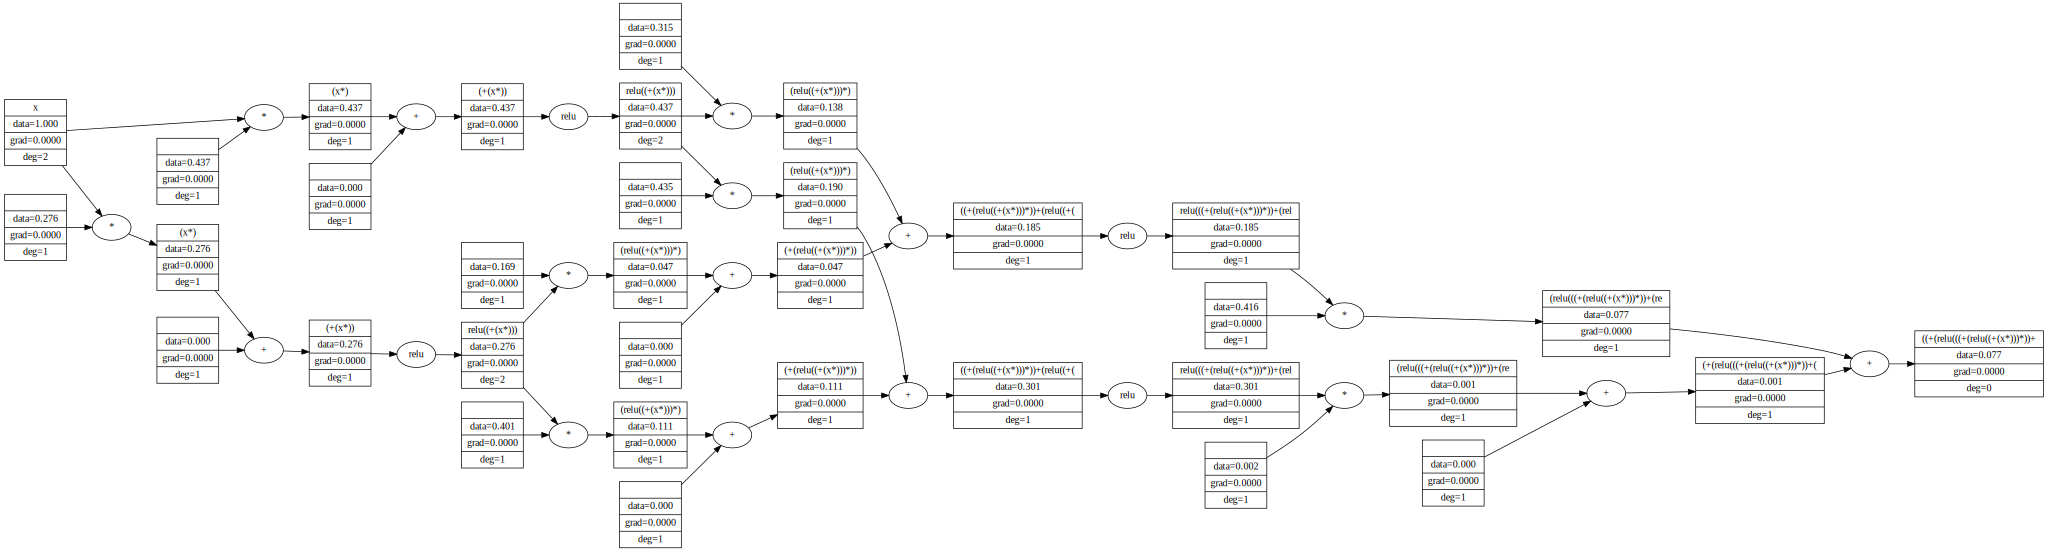

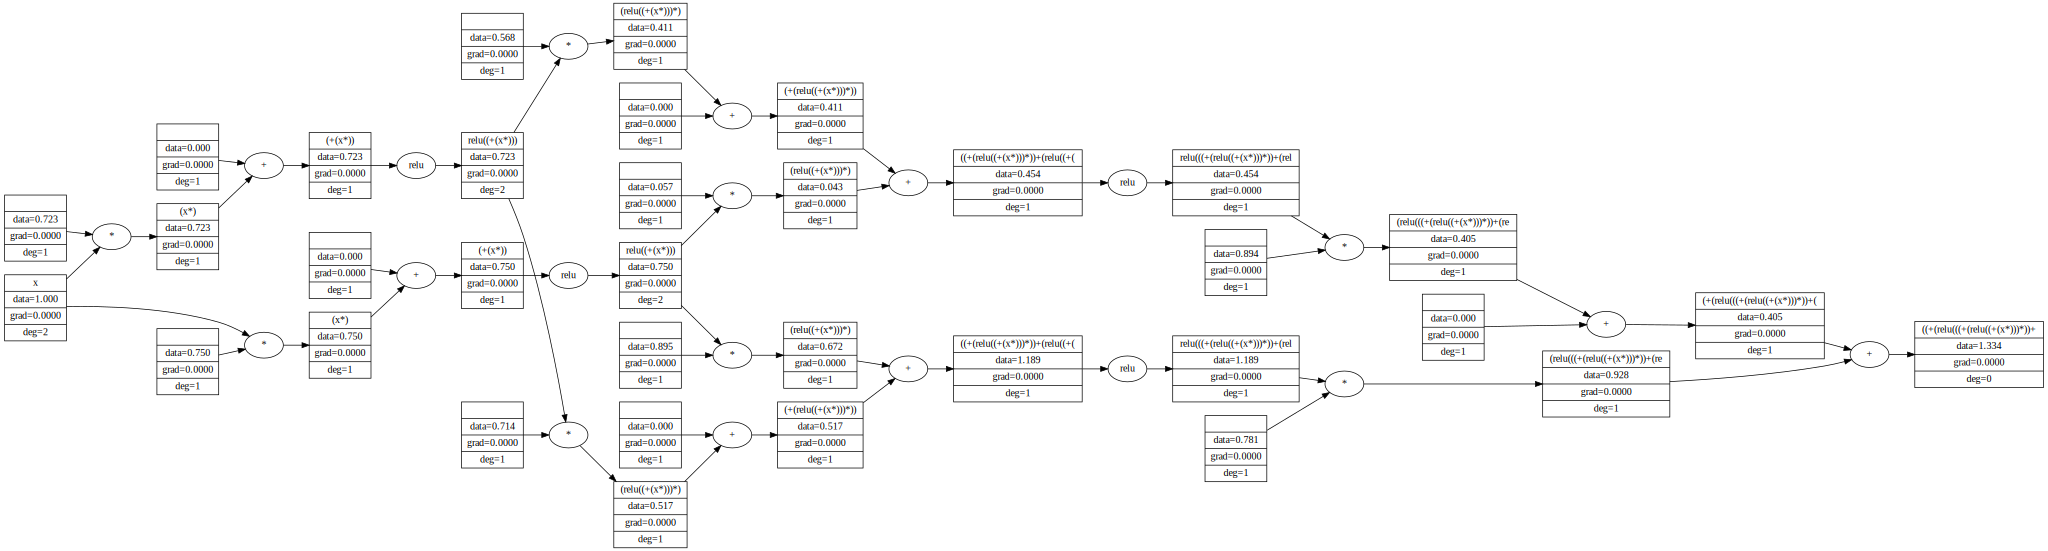

>>>>>>> remote


In [10]:
draw_graph(pred)

### Training the network!

<<<<<<< local
To train a neural network that computes a function $f$, we can think of appending an extra node for the target values, and another compute node for the loss function. The node for the loss takes the output $f(\boldsymbol{\mathsf x})$ and target $\mathsf y$ for each input output pair $(\boldsymbol{\mathsf x}, {\mathsf y})$ in a training step. After computing the global gradients by backpropagation, we update the weights using [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with `λ=0.0001`. SGD is just gradient descent combined with random sampling. 
=======
To train a neural network which computes a function $f,$ we can think of appending an additional node for the target values, and an additional compute node for the loss function which takes in the network output $f(\boldsymbol{\mathsf x})$ and target $\mathsf y$ for each input output pair $(\boldsymbol{\mathsf x}, {\mathsf y})$ in a training step. After computing the global gradients by backpropagation, we update the weights using [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with `λ=0.0001`. This is just gradient descent combined with random sampling. 
>>>>>>> remote


**Dataset.** Our task is to learn the following signal consisting of 200 data points:

<<<<<<< local


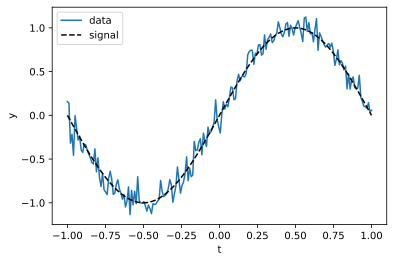

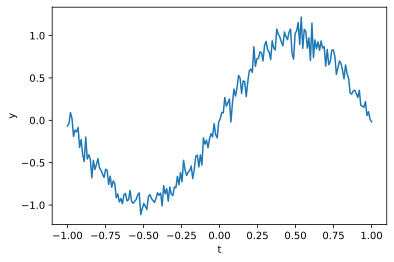

>>>>>>> remote


In [11]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

N = 200
time = np.linspace(-1, 1, N)
y_signal = np.sin(np.pi * time)
y_data = y_signal + 0.1 * np.random.normal(size=N)

plt.plot(time, y_data, label='data')
plt.plot(time, y_signal, 'k--', label='signal')
plt.ylabel('y')
plt.xlabel('t')
plt.legend();

<br>

**Data loader.** Defining a helper for loading the samples:

In [12]:
import random

class DataLoader:
    def __init__(self, dataset):
        """Iterate over a partition of the dataset."""
        self.dataset = [(Node(x, label='x'), Node(y, label='y')) for x, y in dataset]
    
    def load(self, n_samples):
        return random.choices(self.dataset, k=n_samples)

    def __len__(self):
        return len(self.dataset)

<br>

**Optimization.** The function `optim_step` implements one step of gradient descent. The objective of training is to minimize the expected MSE which we approximate by using mini-batches. SGD uses a batch size of 1, so `loss_fn` just computes the MSE between two nodes.

In [13]:
def optim_step(model, eps):
    for p in model.parameters():
        p.data -= eps * p.grad 

def loss_fn(y_pred, y_true):
    return (y_pred - y_true)**2

<br>

**Trainer.** Here `train` runs the training algorithm and keeps a history of the loss at each optimization step for visualization.

<<<<<<< LOCAL CELL DELETED >>>>>>>
**Trainer.** The `train` function runs the training algorithm and keeps a history of the loss at each optimization step for visualization.

In [14]:
from tqdm.notebook import tqdm

def train(model, dataset, n_steps=1):
    dataloader = DataLoader(dataset)    
    history = []
    for x, y in tqdm(dataloader.load(n_steps)):
        model.zero_grad()

        loss = loss_fn(model([x]), y)
        loss.grad = 1.0
        loss.backward()
        optim_step(model, eps=0.0001)

        history.append(loss.data)
    return history

<<<<<<< local
dataset = list(zip(time, y_data))
=======
dataset = list(zip(t, y))
>>>>>>> remote
model = MLP(1, [3, 3, 1], 'tanh')
history = train(model, dataset, n_steps=2000000)

<<<<<<< local


  0%|          | 0/2000000 [00:00<?, ?it/s]

  0%|          | 0/2000000 [00:00<?, ?it/s]

>>>>>>> remote


Observe that the loss curve becomes more stable as we train futher:

<<<<<<< local


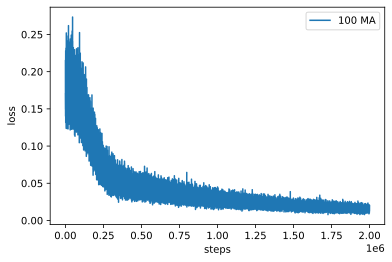

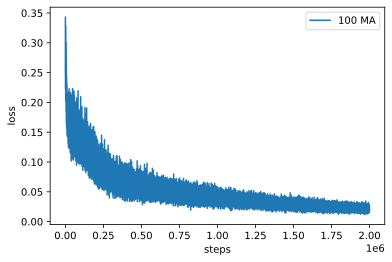

>>>>>>> remote


In [15]:
hist_ma = []
window_size = 100
for i in range(window_size, len(history)):
    hist_ma.append(sum(history[i-window_size:i]) / window_size)

plt.plot(hist_ma, label='100 MA')
plt.ylabel("loss")
plt.xlabel("steps")
plt.legend();

<<<<<<< local


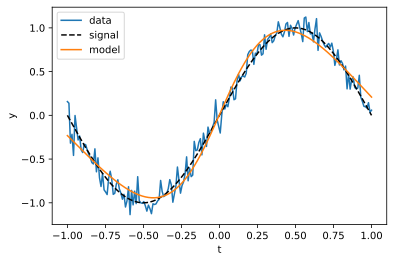

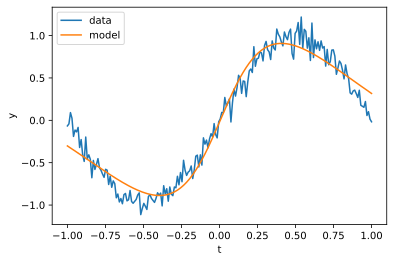

>>>>>>> remote


In [16]:
plt.plot(time, y_data, label='data', color='C0')
plt.plot(time, y_signal, 'k--', label='signal')
plt.plot(time, [model([Node(_)]).data for _ in time], label='model', color='C1')
plt.ylabel('y')
plt.xlabel('t')
plt.legend();

Evaluating with MAE since values are in (0, 1):

In [18]:
y_pred = np.array([model([Node(_)]).data for _ in time])
print(f"MAE (signal): {np.abs(y_pred - y_signal).mean():.2f}")
print(f"MAE (data):   {np.abs(y_pred - y_data  ).mean():.2f}")

MAE (signal): 0.07
MAE (data):   0.10


## Appendix: Backpropagation equations for MLPs

```{margin}
Source:<br>**Figure 1** of {cite}`0483bd9444a348c8b59d54a190839ec9`
```
```{figure} ../../img/deep-nns.png
---
width: 40em
---

This figure should hopefully make sense after reading this article. This figure shows (left) forward pass for a multilayer neural network, and (right) backward pass for the same network.
```

In this section, we solve the backpropagation equations for a fully-connected neural network. This can be useful for analyzing gradient flow during training, e.g. trying to understand the relationship between vanishing (or exploding) gradients with network depth. Forward computation by a fully-connected layer $l$ can be written as a linear preactivation step followed by a nonlinear activation step:

* ${\boldsymbol{\mathsf{y}}}^{[l]} = \boldsymbol{{\mathsf{x}}}^{[l-1]}{\boldsymbol{\mathsf{W}}}^{[l]} + {\boldsymbol{\mathsf{b}}}^{[l]}$ 
* ${\boldsymbol{\mathsf{x}}}^{[l]} = \varphi({\boldsymbol{\mathsf{y}}}^{[l]})$ 

Note that we use row vectors for inputs and outputs of the layer. The backpropagation equations are obtained by simply matching input and output shapes, and then trying to figure out the entries of the right hand side matrix by tracking node dependencies. For the compute nodes in the current layer:
    
$$
\dfrac{\partial \mathcal L}{\partial {\boldsymbol{\mathsf{x}}}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {\boldsymbol{\mathsf{y}}}^{[l+1]}} 
\dfrac{\partial {\boldsymbol{\mathsf{y}}}^{[l+1]}}{\partial {\boldsymbol{\mathsf{x}}}^{[l]}} 
=
\dfrac{\partial \mathcal L}{{\partial \boldsymbol{\mathsf{y}}}^{[l+1]}}
\boldsymbol{\mathsf{W}}^{[l+1]\top}
$$

and

$$
\dfrac{\partial \mathcal L}{\partial {{\boldsymbol{\mathsf{y}}}}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {\boldsymbol{\mathsf{x}}}^{[l]}} 
\dfrac{\partial {\boldsymbol{\mathsf{x}}}^{[l]}}{\partial {\boldsymbol{\mathsf{y}}}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{{\partial \boldsymbol{\mathsf{x}}}^{[l]}}
{{\boldsymbol{\mathsf{J}}}_\varphi}{^{[l]}}.
$$

Here we make the substitution ${\boldsymbol{\mathsf{J}}}_{\varphi} = \frac{\partial {\boldsymbol{\mathsf{x}}}}{\partial {\boldsymbol{\mathsf{y}}}}$ for the Jacobian of the activation $\varphi.$ Most activations are applied entrywise on vector inputs, so that ${\boldsymbol{\mathsf{J}}}_{\varphi}$ reduces nicely to a diagonal matrix. Next, we have the backpropagated gradients for parameter nodes:

$$
\dfrac{\partial \mathcal L}{\partial {\boldsymbol {\mathsf W}}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {{\boldsymbol{\mathsf y}}}^{[l]}} 
\dfrac{\partial {{\boldsymbol{\mathsf y}}}^{[l]}}{\partial {\boldsymbol {\mathsf W}}^{[l]}} 
= 
\boldsymbol{\mathsf{x}}^{[l-1]\top}
\dfrac{\partial \mathcal L}{\partial {{\boldsymbol{\mathsf y}}}^{[l]}} 
$$

and

$$
\dfrac{\partial \mathcal L}{\partial {\boldsymbol{\mathsf{b}}}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {{\boldsymbol{\mathsf y}}}^{[l]}}
\dfrac{\partial {{\boldsymbol{\mathsf y}}}^{[l]}}{\partial {\boldsymbol{\mathsf{b}}}^{[l]}} 
= 
\dfrac{\partial \mathcal L}{\partial {{\boldsymbol{\mathsf y}}}^{[l]}}.
$$

Observe that derivatives of the compute nodes of layer $l+1$ are retrieved to compute gradients in layer $l$ so these have to be stored until the next update. On the other hand, the local gradients ${\boldsymbol {\mathsf J}}_\varphi$ are computed using autodifferentiation and are evaluated at the current network state based on values obtained during forward pass. Also, notice that gradient of the weight $\boldsymbol{\mathsf{w}}_{ij}$ depend only on the value of $\boldsymbol{\mathsf{x}}_{i}$ and the gradient of ${\boldsymbol{\mathsf{y}}_{j}}.$ This allows the network to overfit on the training set by modifying weights at the micro level of pairs of input and output neurons.

<br>

```{figure} ../../img/jacobian.svg
---
name: jacobian
width: 75%
---
Deriving the equations by matching shapes of derivatives as matrices. Trick is to put the incoming gradients as input (blue), and current gradients as output (gray). Figure out the transformation in between containing the local gradients (red).
```


<!-- ### PyTorch `autograd`

The `autograd` package allows automatic differentiation by building computational graphs on the fly every time we pass data through our model. Autograd tracks which data combined through which operations to produce the output. This allows us to take derivatives over ordinary imperative code. This functionality is consistent with the memory and time requirements outlined in above for BP. -->

<!-- import torch

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)
print(device) -->

<!-- **Scalars.** Let $\mathsf{y} = \boldsymbol{\mathsf x}^\top \boldsymbol{\mathsf x} = \sum_i {\mathsf{x}_i}^2.$ In this example, we initialize a tensor `x` which initially has no gradient. Calling backward on `y` results in gradients being stored on the leaf tensor `x`. Note that unlike our implementation, there is no need to set `y.grad = 1.0`. Moreover, doing so would result in an error as `y` is not a [leaf node](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html) in the graph. -->

<!-- x = torch.arange(4, dtype=torch.float, requires_grad=True)
y = x.T @ x 

y.backward() 
(x.grad == 2*x).all() -->

<!-- **Vectors.** Let $\boldsymbol{\mathsf y} = g(\boldsymbol{\mathsf x})$ and let $\boldsymbol{\mathsf v}$ be a vector having the same length as $\boldsymbol{\mathsf y}.$ Then `y.backward(v)` implements   

$$\sum_i {\mathsf v}_i \left(\frac{\partial {\mathsf y}_i}{\partial {\mathsf x}_j}\right)$$ 
  
resulting in a vector of same length as `x` stored in `x.grad`. Note that the terms on the right are the local gradients in backprop. Hence, if `v` contains backpropagated gradients of nodes that depend on `y`, then this operation gives us the backpropagated gradients with respect to `x`, i.e. setting ${\mathsf v}_i = \frac{\partial \mathcal{L} }{\partial {\mathsf y}_i}$ gives us the vector $\frac{\partial \mathcal{L} }{\partial {\mathsf x}_j}.$ -->

<!-- x = torch.rand(size=(4,), dtype=torch.float, requires_grad=True)
v = torch.rand(size=(2,), dtype=torch.float)
y = x[:2]

# Computing the Jacobian by hand
J = torch.tensor(
    [[1, 0, 0, 0],
    [0, 1, 0, 0]], dtype=torch.float
)

# Confirming the above formula
y.backward(v)
(x.grad == v @ J).all() -->

<!-- **Locally disabling gradient tracking.** Disabling gradient computation is useful when computing values, e.g. accuracy, whose gradients will not be backpropagated into the network. To stop PyTorch from building computational graphs, we can put the code inside a `torch.no_grad()` context or inside a function with a `@torch.no_grad()` decorator.

Another technique is to use the `.detach()` method which returns a new tensor detached from the current graph but shares the same storage with the original one. In-place modifications on either of them will be seen, and may trigger errors in correctness checks. -->